<h1 style="font-size:30px;">Average Precision (AP)</h1>


Here are predictions from two taxi detection models. In both images:
- **`Yellow bounding boxes`** are ground truths.
- **`Red bounding boxes`** are predictions from `model-1` in `image-1`.
- **`Blue bounding boxes`** are predictions from `model-2` in `image-2`.


---

<table><tr>
<td><img src="https://www.learnopencv.com/wp-content/uploads/2020/10/c4-w8-taxi-AP-1.jpg" alt="Drawing" style="width: 500px;"></td>
<td> <img src="https://www.learnopencv.com/wp-content/uploads/2020/10/c4-w8-taxi-AP-2.jpg" alt="Drawing" style="width: 500px;"></td>
</tr></table>

<center>Reference: <a href="https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=detection&c=%2Fm%2F0pg52&id=2ac173481983c3a4">Open Images Datasets</a></center>

---

**By looking at these two images, can you tell which object detection model is better?**


Before jumping to any conclusion, let us list a few observations:

- All taxis are detected in `image-1`, but one car is also mistakenly detected as a taxi (**false positive**).


- In `image-2`, there are only two detections, one is a taxi and the second is for two taxis combined. There seem to be no **false positives** though. 


**More than answers, these models give rise to questions like should the two taxis enclosed in one bounding box in image-2 be counted as two taxis or a single taxi?**


Based on the above observations, it is difficult to determine which model is better.
- While one model is predicting a **false positive**
- The other is giving a single bounding box for two taxies; perhaps it should be counted as one missing detection (**false negative**).

So these observations emphasize the need for an evaluation metric that quantifies the superiority of an object detection model. One metric that is widely accepted as metric for object detection is called **mean Average Precision (mAP)**.

## Table of Contents

* [1 Building Blocks of Detection Metric](#1-Building-Blocks-of-Detection-Metric)
* [2 Average Precision Algorithm](#2-Average-Precision-Algorithm)
* [3 Check the Implementation](#3-Check-the-Implementation)
* [4 Mean Average Precision (mAP)](#4-Mean-Average-Precision-%28mAP%29)
* [5 References](#5-References)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.patches as patches

from collections import defaultdict

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 10)
block_plot = False

## 1 Building Blocks of Detection Metric

**To fully understand the average precision metric and use it effectively, you need to understand each of the components used to compute it. So let’s study the following components, one by one:**

- Intersection over Union (IoU)

- True Positive (TP)

- False Positive (FP)

- False Negative (FN)

- Precision

- Recall

### 1.1 Intersection over Union (IoU)

As you know, that **IoU** measures the proximity of two bounding boxes. Here, IoU is required to measure **how close the ground-truth bounding box is to the predicted bounding box**. 


You are already pretty familiar with IoU, so let's just quickly summarize here.

<img src='https://www.learnopencv.com/wp-content/uploads/2020/10/c4-w8-IoU.png' width="800">


$$
\text{IoU} = \frac{\text{intersection_area}}{\text{union_area}} = \frac{\text{intersection_area}}{\text{area_bounding_box}_1 + \text{area_bounding_box}_2 - \text{intersection_area}}
$$

Even though the IoU code has already been discussed in detail, here we simply rewrite the code in order to use in the AP evaluation metric.

`get_iou()` runs on every image:
- This method calls one predicted bounding box and all ground-truth bounding boxes of a single image
- Tt returns the IoU of the predicted bounding box with ground-truth bounding boxes.

In [ ]:
# Compute intersection over union of detected boxes with GTs.
def get_iou(predicted_dbox, ground_truth_dboxes):
    """
        Calculates IoU (Jaccard index) of two detection boxes:
            predicted_dbox ∩ ground_truth_dbox / (area(predicted_dbox) +
            area(ground_truth_dbox) - predicted_dbox ∩ ground_truth_dbox)

        Parameters:
            Coordinates of detection boxes are supposed to be in the following form: [x1, y1, x2, y2]
            predicted_dbox: [tensor] predicted detection boxe
            ground_truth_dboxes: [tensor] ground truth detection boxes

        Return value:
            overlap area
    """
    # Get coordinates of boxes to prepare overlap data.
    ixmin = tf.math.maximum(ground_truth_dboxes[:, 0], predicted_dbox[0])
    iymin = tf.math.maximum(ground_truth_dboxes[:, 1], predicted_dbox[1])
    ixmax = tf.math.minimum(ground_truth_dboxes[:, 2], predicted_dbox[2])
    iymax = tf.math.minimum(ground_truth_dboxes[:, 3], predicted_dbox[3])

    width = tf.math.maximum(ixmax - ixmin + 1., tf.Variable(0.))
    height = tf.math.maximum(iymax - iymin + 1., tf.Variable(0.))
    intersection_area = width * height

    # Calculate the union value.
    union = ((predicted_dbox[2] - predicted_dbox[0] + 1.) * (predicted_dbox[3] - predicted_dbox[1] + 1.) +
             (ground_truth_dboxes[:, 2] - ground_truth_dboxes[:, 0] + 1.) *
             (ground_truth_dboxes[:, 3] - ground_truth_dboxes[:, 1] + 1.) - intersection_area)

    return intersection_area / union

Any predicted bounding box should have a single mapping with ground-truth bounding boxes. Logically it should be the ground-truth that has maximum `IoU` with the predicted bounding box. The function below, `check_iou_threshold()`  performs this mapping with the following steps.
- It takes a predicted bounding box and all the ground-truths of an image
- It uses `get_iou` to get IoUs and then finds its maximum `IoU` and corresponding index
- Compares the maximum `IoU` to see if it is greater than the `IoU threshold` and returns the boolean value and the index of the maximum IoU value

In [ ]:
# Check if intersections of predicted and ground-truth boxes are greater than predefined threshold.
def check_iou_threshold(predicted_dboxes, ground_truth_dboxes, intersection_threshold):
    """
        Get the predictions with an appropriate IoU area for further true positives computations

        Parameters:
        predicted_dboxes: predicted by the detector detection boxes
        ground_truth_dboxes: ground truth
        intersection_threshold: IoU threshold

        Return value:
            tensor with the following values:
                    True - if the IoU passed defined threshold
                    False - if the IoU did not pass defined threshold
            index of the maximum IoU value
    """
    intersection_over_union = get_iou(predicted_dboxes, ground_truth_dboxes)
    return tf.math.reduce_max(intersection_over_union
                             ) >= intersection_threshold, tf.math.argmax(intersection_over_union)

Let's now take examples of ground truth and predicted bounding boxes from a single image and run `check_iou_threshold` on them. It is better to plot these bounding boxes so that we can visually verify our implementation. For this purpose, we define the function below, `plot_groundtruth_prediction_boxes()`, to plot the ground truth and predicted bounding boxes with their probabilities. 

In [ ]:
def plot_groundtruth_prediction_boxes(ground_truths, predictions):
    """
    "Plots ground truth and prediction bounding boxes"
    
    Parameters:
    
    gt_bboxes (list): a list of ground truths. 
                      Format: 
                      [
                          [Image_ID(str), [x_min, y_min, x_max, y_max] (tf.Variable)],
                          [Image_ID(str), [x_min, y_min, x_max, y_max] (tf.Variable)],
                                         :
                                         :
                          [Image_ID(str), [x_min, y_min, x_max, y_max] (tf.Variable)]
                             
                      ] 
                             
    pred_bboxes (list): a list of detected bounding box data containing ImageID, boxes, conf. scores. 
                        Format: 
                        [
                          [Image_ID(str), [x_min, y_min, x_max, y_max](tf.Variable), prob_1(tf.Variable)],
                          [Image_ID(str), [x_min, y_min, x_max, y_max](tf.Variable), prob_2(tf.Variable)],
                                                     :
                                                     :
                          [Image_ID(str), [x_min, y_min, x_max, y_max](tf.Variable), prob_n(tf.Variable)]
                             
                        ] 
    """
    
    box_data = [ground_truths, predictions]
    
    sorted_ind = [i for i,_ in sorted(enumerate(predictions), key=lambda conf: conf[1][2], reverse=True)]

    
    colors = ['b', 'r']
    label_prefix = ['g-truth', 'pred']
        
    fig = plt.figure()       
    
    ax = fig.add_subplot(111, aspect='equal')
    
    for boxtype_i, boxes in enumerate(box_data):
        
        dbox_data = tf.stack([box[1] for box in boxes])
    
        width = dbox_data[:, 2] - dbox_data[:, 0] + 1
        height = dbox_data[:, 3] - dbox_data[:, 1] + 1
    
        for i in range(tf.shape(dbox_data)[0]):
            
            # Ground Truths.
            if boxtype_i == 0:
                index = i
                label = '{}. {}'.format(index, label_prefix[0])
                x_label = dbox_data[index, 0] + 8
                y_label = dbox_data[index, 3] - 10
                
            # Detections.    
            else:
                index = sorted_ind[i]
                label = '{0}. {1}({2:.2})'.format(index, label_prefix[1], predictions[index][2].numpy())
                x_label = dbox_data[index, 0] + 8
                y_label = dbox_data[index, 1] - 10
                
            ax.add_patch(
                patches.Rectangle(
                    (dbox_data[index, 0], dbox_data[index, 1]),
                    width[index],
                    height[index],
                    fill=False,      # remove background
                    color=colors[boxtype_i],
                    linewidth = 3,
            )
            )
            
            
            
            ax.text(x_label, y_label, label, color=colors[boxtype_i], 
                    bbox=dict(facecolor='none', edgecolor=colors[boxtype_i]))
        
    
    plt.xticks(range(0, 1550, 50))
    plt.yticks(range(0, 1050, 50))
        
    plt.gca().invert_yaxis()
    plt.show(block=block_plot)
    
    return

**Here is an example of ground truth and predicted bounding boxes.  There is also a bounding box confidence score.** 

In [ ]:
# bounding boxes / detection
ground_truths = [
                 ['1', tf.Variable([ 100, 500,  300, 950], dtype=tf.float32)], 
                 ['1', tf.Variable([ 350, 550,  570, 930], dtype=tf.float32)],
                 ['1', tf.Variable([ 600, 200,  850, 600], dtype=tf.float32)],
                 ['1', tf.Variable([ 900, 10,  1100, 380], dtype=tf.float32)],
                 ['1', tf.Variable([ 980, 500, 1200, 950], dtype=tf.float32)],
                 ['1', tf.Variable([1250, 300, 1470, 800], dtype=tf.float32)],
                ]

# bounding boxes / detection
detections = [
               ['1', tf.Variable([ 120, 450,  325, 900], dtype=tf.float32), tf.Variable(.67)], 
               ['1', tf.Variable([ 340, 500,  580, 970], dtype=tf.float32), tf.Variable(.87)],
               ['1', tf.Variable([ 620, 300,  870, 800], dtype=tf.float32), tf.Variable(.65)],
               ['1', tf.Variable([ 820, 180, 1170, 440], dtype=tf.float32), tf.Variable(.56)],
               ['1', tf.Variable([1000, 550, 1220, 980], dtype=tf.float32), tf.Variable(.89)],
               ['1', tf.Variable([1300, 320, 1450, 750], dtype=tf.float32), tf.Variable(.99)],
               ['1', tf.Variable([ 350, 100,  580, 450], dtype=tf.float32), tf.Variable(.51)],
               ['1', tf.Variable([ 950, 490, 1180, 960], dtype=tf.float32), tf.Variable(.83)],
             ]

2022-04-06 22:04:17.216624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 22:04:17.216652: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 22:04:17.216671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kunal-hp-pavilion-x360-convertible-14-ba0xx): /proc/driver/nvidia/version does not exist
2022-04-06 22:04:17.217202: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's keep in mind that we would typically have ground truths across multiple images, and for each such image, we  have detections predicted by our model as well. We should also remember that we would have ground truths and detections across multiple classes as well. However, in this notebook, we shall restrict ourselves to performing all computations based on a **single class** for simplicity. So, it becomes imperative that we associate each image with an **ImageID** so that we can keep a track of them which is required to calculate the **mAP** score. However, for now, we would consider all ground truth and detections for a single image only. Further below in this notebook, we will also handle the case of multiple images.


The format of our `ground_truths` and `detections` are as follows:

*  **`ground_truths`**: Each ground truth is a **list** containing:
    * an **ImageID (`str`)** - indicating the image to which it belongs to, and
    * **BBox data(`tf.Variable`)** - which essentially contains 4 coordinates: $[x_{min}, y_{min}, x_{max}, y_{max}]$.
    
    
*  **`detections`**: Each detection is a **list** containing:
    * an **ImageID (`str`)** - indicating the image to which it belongs to, 
    * **BBox data(`tf.Variable`)** - which essentially contains 4 coordinates: $[x_{min}, y_{min}, x_{max}, y_{max}]$, and
    * **Confidence Score(`tf.Variable`)** - which contains the confidence score for each detected box.


**Now, let's plot the ground truth and predicted bounding boxes with its confidence probability score.**

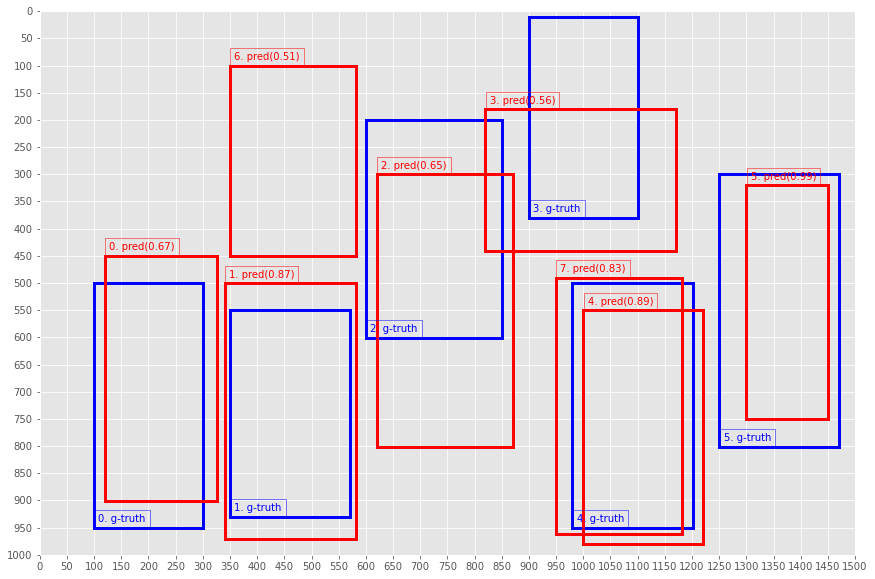

In [ ]:
plot_groundtruth_prediction_boxes(ground_truths, detections)

You can clearly see that there are:
- **six `(0-5)`** ground truth bounding boxes
- **eight `(0-7)`** predicted bounding boxes (detections). 

Next, we run **`check_iou_threshold`** for all eight detections. Let us prioritize each detection based on its confidence score, which is necessary for computing the average precision.

In [ ]:
# Get the indices of sorted prediction confidence. 
# The negative sign is used to make it in decreasing order. 
# These indices will be used to prioritize detection. 
s_ind = [i for i,_ in sorted(enumerate(detections), key=lambda conf: conf[1][2], reverse=True)]

all_gt_dboxes = tf.stack([gt[1] for gt in ground_truths])

# The IoU threshold.
iou_thres = 0.5

for i, s_index in enumerate(s_ind):
    print('Predicted Bounding Box index: {0}, prob: {1:0.3}'.format(s_index, detections[s_index][2].numpy()))
    qualified_iou_thres, gt_index = check_iou_threshold(detections[s_index][1], all_gt_dboxes, 
                                                        intersection_threshold=iou_thres)
    print('Is any g-truth box has IoU more than {0:.2}: {1}'.format(iou_thres, qualified_iou_thres))
    print('The g-truth that has maximum IoU with pred-box, {0}({1:.2}): {2}'.format(s_index, detections[s_index][2].numpy(), 
                                                                                    gt_index))
    
    print('------'*10)

Predicted Bounding Box index: 5, prob: 0.99
Is any g-truth box has IoU more than 0.5: True
The g-truth that has maximum IoU with pred-box, 5(0.99): 5
------------------------------------------------------------
Predicted Bounding Box index: 4, prob: 0.89
Is any g-truth box has IoU more than 0.5: True
The g-truth that has maximum IoU with pred-box, 4(0.89): 4
------------------------------------------------------------
Predicted Bounding Box index: 1, prob: 0.87
Is any g-truth box has IoU more than 0.5: True
The g-truth that has maximum IoU with pred-box, 1(0.87): 1
------------------------------------------------------------
Predicted Bounding Box index: 7, prob: 0.83
Is any g-truth box has IoU more than 0.5: True
The g-truth that has maximum IoU with pred-box, 7(0.83): 4
------------------------------------------------------------
Predicted Bounding Box index: 0, prob: 0.67
Is any g-truth box has IoU more than 0.5: True
The g-truth that has maximum IoU with pred-box, 0(0.67): 0
------

**The above output can be summarized as follows:**

- Detections `5`, `4`, `1`, `7`, and `0` have IoU greater than the threshold `0.5` with ground-truth `5`, `4`, `1`, `4`, and `0`, respectively.


- Detections `4` and `7` have the highest IoU with the same ground-truth, `4`. 


- Detections `2`, `3`, and `6` did not qualify the IoU threshold criteria. 

### 1.2 True / False Positive and False Negative

**Here, we will define these quantities in the context of Object Detection.**

### <font style="color:rgb(50,120,230)"> True Positive (TP) </font>


**Correctly detected objects.** A detection is a True Positive (TP) if it satisfies the following conditions:

- **`confidence score > score threshold`:** Only those predicted boxes which have a confidence score greater than the score_treshold qualify for being a **True-Positive**.


- **`IoU > IoU threshold`:** Only those detections whose IoU with any ground truth is greater than the IoU threshold are candidates for the right detection.  Further, it will qualify for the right detection if the ground truth (with maximum and more than threshold IoU) is not already assigned to any other prediction. 
Here, the detection with a higher confidence will be given more priority. 

For example, detection `4 (0.89)` and `7 (0.83)` both have maximum overlap (also greater than the threshold) with ground-truth `4`. However, one ground-truth cannot be associated with more than one prediction..  
Hence, we consider the detection **`4 (0.89)` as true-positive** and detection **`7 (0.83)` as false-positive**. 

### <font style="color:rgb(50,120,230)"> False Positive (FP)</font>


**Incorrectly detected objects.** A detection is a False Positive (FP) if it satisfies the following conditions:

- **`confidence score < score threshold`:** Any detection that has lower confidence than the score threshold will be considered **false-positive**. However, in our above plot, there is no such detection.  Also, there is no code implementation to check it in the notebook. This means we are getting detections after filtering based on the score threshold. 

- **`IoU < IoU threshold`:** Even if the detection has a high confidence (than score threshold), but it's IoU with some ground truth is not good enough (lower than IoU threshold), then the detection will be considered as false-positive. `IoU = 0` being only a special case.

For example, Detections `2`, `3`, and `6` did not qualify the IoU threshold criteria, so these detections are false positives. 

Therfore, False-Positives are basically those detections that don't have sufficient IoU with any ground-truth boxes.

### <font style="color:rgb(50,120,230)"> False Negative (FN) </font>

**GT boxes that do not have a corresponding detection with sufficient IoU and confidence score.**

If a ground truth does not have a detection associated with it, then we consider the ground-truth as a false negative. 

For example, ground truth `2` and `3` do not have sufficient IoU with any of the detections, they are false negatives. 

**Note:** **True Positives** and **False Positives** are always in reference to the **detections**, whereas, **False Negatives** are in reference to the **ground-truths**.

The method `match()` calculates True Positives and False Positives using `check_iou_threshold()`

In [2]:
def match(sorted_ind, detections, gts_per_image, intersection_threshold, debug=False):
    """
    match detected boxes with ground-truth boxes.
    
    Parameters:
        sorted_ind: Indicies corresponds to the sorted negative of confidence score.
        
        detections: Contains info on the detections predicted by the model.
        
        gts_per_image: A dictionary which maintains all ground truths based on ImageID.
        
        intersection_threshold: IoU threshold
        
        debug: boolean, to print logs. default is false.

    Return value:
        true_positives: A tensor of boolean values
        false_positives: A tensor of boolean values
    
    
    
    """
    # Define true positives and false positives TF tensors.
    true_positives = tf.Variable(tf.zeros((len(sorted_ind)), dtype=tf.float64))
    false_positives = tf.Variable(tf.zeros((len(sorted_ind)), dtype=tf.float64))

    # Prepare the boolean list for further check whether the object for that particular image
    # has been already detected.
    is_obj_already_detected = {key: np.full((len(gts_per_image[key]), ), False) for key in gts_per_image}

    # For each box decide if it is a true positive or a false positive.
    for i, box_num in enumerate(sorted_ind):
        
        # Get the detection (a list containing ImageID, BBox and conf. score) based on sorted_ind.
        det = detections[box_num]
        
        # Get the detected BBox.
        predicted_dbox = det[1]
        
        # Stack all ground truths based on the ImageID from det.
        all_gt_dboxes = tf.stack([gt[1] for gt in gts_per_image[det[0]]])

        is_pass_threshold, max_iou_index = check_iou_threshold(
            predicted_dbox, all_gt_dboxes, intersection_threshold
        )
        # Note that "true_positives" and "false_positives" are updated with "i" and not with sorted index. 
        # This is being done so that higher confident detections should be prioritized. 
        if is_pass_threshold and not is_obj_already_detected[det[0]][max_iou_index]:
            true_positives[i].assign(1)
            is_obj_already_detected[det[0]][max_iou_index] = True
            if debug:
                print('Predicted box no {} is true positive.'.format(box_num))
        else:
            false_positives[i].assign(1)
            if debug:
                print('Predicted box no {} is false positive.'.format(box_num))

    return true_positives, false_positives

**Let us call `match` with debug true.**

In [ ]:
gts_per_image = defaultdict(list)
for gt in ground_truths:
    gts_per_image[gt[0]].append(gt)

t_positive, f_positive = match(sorted_ind=s_ind, 
                               detections=detections, 
                               gts_per_image=gts_per_image, 
                               intersection_threshold=iou_thres, 
                               debug=True)

print('\nTrue positives: {}, \nFalse positives: {}'.format(t_positive.numpy(), f_positive.numpy()))

Predicted box no 5 is true positive.
Predicted box no 4 is true positive.
Predicted box no 1 is true positive.
Predicted box no 7 is false positive.
Predicted box no 0 is true positive.
Predicted box no 2 is false positive.
Predicted box no 3 is false positive.
Predicted box no 6 is false positive.

True positives: [1. 1. 1. 0. 1. 0. 0. 0.], 
False positives: [0. 0. 0. 1. 0. 1. 1. 1.]


The above output identifies the true positives and false positives.

**Note:** **`true_positives`** and **`false_positives`** tensors are not ordered based on the actual detection number but on the sorted (decreasing order) confidence score. 

### 1.3. Precision / Recall


### <font style="color:rgb(50,120,230)">Precision</font>

Precision is the ratio of true positives to the sum of true positives and false positives in the obtained results. As you can see, the sum of `TP` and `FP` is equal to total detections. In other words, precision is the fraction of total detections that were correct. Mathematically it is written as follows:

$$ \text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} =
\frac{\text{TP}}{D},$$
   where $D$ is the total number of detections.


### <font style="color:rgb(50,120,230)">Recall</font>

Recall is the ratio of true positives to the sum of true positives and false negatives. The sum of true positives and false negatives is nothing but the total number of ground-truths. In other words, recall is the fraction of ground truth bounding boxes that were correctly detected. Mathematically it is written as follows:

 $$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} =
  \frac{\text{TP}}{G},$$
 where $G$ is the total number of ground-truth objects.

## 2 Average Precision Algorithm

Thus far, we have only discussed the components of the average precision algorithm intuitively. Let's now write the algorithm formally.

**Computation pipeline in the object detection context is the following:**

1. For a given confidence threshold:
     * Select detections with confidences higher than the **confidence threshold**
     * Find the correspondence between the detections and ground truths:
         * Sort the detections according to their scores in descending order
         * Compute the **Intersection over Union (IoU)** of each detection box with all the GT
           bounding boxes for that **ImageID**.
         * For each detection, find the ground truth (for that **Image**) with the highest IoU higher than the
           **IoU threshold**
     * Define and count **true positives, false positives and false negatives** values.
         * All detections associated with ground truths (for that **Image**) that have only one match
           are considered **true positives**
         * In case the ground truth object has more than one associated detection:
             - The associated detection having the highest score is considered **true
               positives**
             - Other detections for that **Image** are considered as **false positives**
         * All detections that have no associated ground truth objects (due to too
           low IoUs) are considered **false positives**
         * All ground truths that have no associated predictions are **false negatives**. 
     * Calculate **recall** and **precision** with the given numbers of **TP, FP** and **ground
       truth objects**
2. After step 1, we have **precision** at some **recall points** - interpolate the
   obtained precision at all other points
3. Calculate the **Average Precision (AP)** as the area under the interpolated curve

While computing pairs of recall and precision at confidence thresholds, we
can plot a precision-recall curve: 
- `x-axis` is recall 
- `y-axis` - precision.

### 2.1 11-Point Interpolation

In practice, researchers typically use an interpolated version of the recall-precision curve. In this case, we do not estimate the recall-precision pairs for every possible confidence threshold. Instead, we select some points, measure the recall and precision in them, and interpolate all the values in between. To compute the interpolated precision, we use the maximum value for the specified recall level:

$$p_{\text{interp}}(r) = \underset{r':r'\geq r}\max{p(r')}$$

After defining all the components, we can evaluate the mean average precision value. According to [The PASCAL Visual Object Classes (VOC) Challenge](http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf), the
mean precision at a set of eleven equal recalls defines the AP:

$$AP_{11-points} = \frac{1}{11}\sum_{r\in{\{0, 0.1,...,1\}}}{p_{\text{interp}}(r)}$$

Thus, AP summarizes the interpolated precisions at `11` recall areas from  `0` to `1: 0.0, 0.1, ..., 1`.

### 2.2 Interpolating All Points

Instead of interpolating only in the 11 equally spaced points, we could interpolate through all points as follows:

$$p_{\text{interp}}(r_{n+1}) = \underset{r':r'\geq r_{n+1}}\max{p(r')}$$

According to the [The PASCAL Visual Object Classes (VOC) 2010 Challenge](http://host.robots.ox.ac.uk/pascal/VOC/voc2010/devkit_doc_08-May-2010.pdf) metric, AP is defined as:

$$AP_{all-points} = \sum_{n=0}{(r_{n+1} - r_{n})p_{\text{interp}}(r_{n+1})}$$

**So now let's implement a Class that we can use to compute this metric.**

In [ ]:
# The core class for running average precision pipeline.
class AveragePrecisionEvaluator:
    def __init__(self, intersection_threshold=0.5, use_07_metric=False, points_number=11, debug=False):
        
        # Keep track of all ground truths per ImageID.
        self.gts = defaultdict(list)
        # Create 11 recall points, on these points precesion will be interpolated. 
        self.recall_levels = tf.cast(tf.linspace(0., 1., points_number), dtype=tf.float64)
        # Predefined intersection threshold.
        self.intersection_threshold = intersection_threshold
        # Init recalls and precisions to fill them with approprite values in run_ap_calculation method.
        self.recalls = None
        self.precisions = None
        # Init average precision for futher computation
        self.average_precision = 0.
        self.true_positives = None
        self.false_positives = None
        self.false_negatives = None
        self.use_07_metric = use_07_metric
        self.debug = debug
        
        self.precision_levels = tf.Variable(tf.zeros((points_number), dtype=tf.float64))
            

    # calculate ap
    def run_ap_calculation(self, detections, ground_truths):
        """
            Initiate AP calculation process

            Parameters:
            
                detections: Contains info on the detections predicted by the model.
                            Each detection is a list of ImageID(str), BBox(tf.Variable)
                            and conf. score(tf.Variable)
        
                ground_truths: Contains info on the ground truth objects.
                               Each ground truth is a list of ImageID(str), BBox(tf.Variable)

            Return value:
                VOC mean average precision
        """
        # Sort predicted_dboxes based on their confidence scores
        sorted_ind = [i for i,_ in sorted(enumerate(detections), key=lambda conf: conf[1][2], reverse=True)]

        # Initialize true positives and false positives TF tensors with 0 for each detected object.
        true_positives = tf.Variable(tf.zeros((len(sorted_ind)), dtype=tf.float64))
        false_positives = tf.Variable(tf.zeros((len(sorted_ind)), dtype=tf.float64))

        if len(ground_truths) == 0:
            false_positives = tf.Variable(tf.ones((len(sorted_ind)), dtype=tf.float64))
        
        else:
            for g in ground_truths:
                self.gts[g[0]].append(g)
            # Get filled true positives and false positives TF tensors.
            true_positives, false_positives = match(
                sorted_ind, detections, self.gts, self.intersection_threshold
            )

        # Get true positives cumulative sum to obtain its value.
        self.true_positives = tf.math.cumsum(true_positives, axis=0)

        # Get false positives cumulative sum to obtain its value.
        self.false_positives = tf.math.cumsum(false_positives, axis=0)


        # Calculate precisions.
        self.precisions = self.true_positives / (
            self.false_positives + self.true_positives + np.finfo(float).eps
        )

        # Calculate recalls.
        self.recalls = self.true_positives / len(ground_truths)
        
        if self.debug:
            print("\n{0}run_ap_calculation{0}".format('--'*20))
            print('true positives and false positives returned from the "match" method:'
                  '\ntrue_positives:\t\t{}\nfalse_positives:\t{}'.format(true_positives.numpy(), 
                                                                       false_positives.numpy()))
            print('\ntrue positives and false positives after cumulative sum:'
                  '\nself.true_positives:\t{}\nself.false_positives:\t{}'.format(self.true_positives, 
                                                                                 self.false_positives))
    
            print('\nprecision calculated using true positive and false positive:\n'
                  'self.precisions:\t{}'.format(self.precisions))
            print('\nrecall calculated using true positive and false negative:\n'
                  'self.recalls:\t\t{}'.format(self.recalls))

        # Return VOC mAP value.
        return self.get_voc_ap()

    # calculate VOC mAP
    def get_voc_ap(self):
        """
            Evaluates VOC Mean Average Precision

        """
        # Define average precision tensor.
        self.average_precision = tf.Variable(0, dtype=tf.float64)
        
        # Check whether recalls and precisions values were recalculated.
        if self.precisions is None or self.recalls is None:
            self.average_precision = tf.Variable(np.nan)
            return self.average_precision
        
        if self.use_07_metric:

            # Iterate over recall levels.
            for i, recall_level in enumerate(self.recall_levels):
                # Get tensor of boolean values where recalls are greater or equal to recall level.
                recalls_check = tf.math.greater_equal(self.recalls, recall_level)

                # Check the sum of True values from recalls_check tensor.
                if tf.math.reduce_sum(tf.cast(recalls_check, tf.float64)) == 0.:
                    val = tf.Variable(0., dtype=tf.float64)
                else:
                    # Precision needs to be interpolated at different points of recall. 
                    # Precision at any point of recall will be equal to maximum precision 
                    # among all precisions correspond to all recalls greater than or equal to the recall point. 
                    val = tf.math.reduce_max(self.precisions[recalls_check])

                self.precision_levels[i].assign(val)

                # Update average_precision with value.
                self.average_precision = self.average_precision + val

            # Get mean average precision.
            self.average_precision = self.average_precision / float(self.recall_levels.shape[0])

            
            print("\n{0}get_voc_ap_11_points{0}".format('--'*21))           
            print('\n{} recall points:\n{}'.format(len(self.recall_levels), self.recall_levels))
            print('\n{}-points interpolated precision:\n{}'.format(len(self.recall_levels), 
                                                                   self.precision_levels.numpy()))
            print('\n{}-points average precision:\t{}'.format(len(self.recall_levels), 
                                                              self.average_precision))
                
        else:
            
            mean_recall = tf.concat([[0.], self.recalls, [1.]], axis=-1)
            mean_precision = tf.concat([[0.], self.precisions, [0.]], axis=-1)
            
            # Compute the precision envelope.
            for i in range(mean_precision.shape[0] - 1, 0, -1):
                changed_precision = tf.maximum(mean_precision[i - 1], mean_precision[i])
                mean_precision = tf.tensor_scatter_nd_update(mean_precision, [[i-1]], [changed_precision])
                      
            # To calculate area under PR curve, look for points
            # where X axis (recall) changes value.    
            idx = tf.squeeze(tf.where(mean_recall[1:] != mean_recall[:-1]), axis=-1)

            
            self.average_precision= tf.math.reduce_sum(
                                        tf.multiply((tf.gather(mean_recall,idx+1) - tf.gather(mean_recall,idx)),
                                            tf.gather(mean_precision, idx+1)))
            
            
            self.recall_levels = mean_recall[:-1]
            self.precision_levels = mean_precision[:-1]
            
            
            print("\n{0}get_voc_ap_all_points{0}".format('--'*21))
            print('\nRecall points:\n{}'.format(self.recall_levels))
            print('\nAll-points interpolated precision:\n{}'.format(self.precision_levels.numpy()))
            print('\nAll-points average precision:\t{}'.format(self.average_precision.numpy()))
                

        return self.average_precision

    # Plot precision recall curve.
    def precision_recall_curve(self):
        """
            Precision-recall curve visualization for specified class

            Parameters:
                experiment_name: title of the running experiment
        """
        # Plot the curve.
        fig, ax = plt.subplots(figsize=(15,10))
        ax.set_ylim([-0.05, 1.05])
        
        if self.use_07_metric:
            
            ax.plot(self.recalls, self.precisions, label='precision-recall')
            ax.plot(self.recall_levels.numpy(), self.precision_levels.numpy(), '*', 
                     label='{}-points interpolation'.format(len(self.recall_levels)))
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='best')

            plt.show(block=block_plot)
        
        else:
            recalls = self.recall_levels.numpy()
            interp_prec = self.precision_levels.numpy()
            
            ids = np.where(recalls[1:]!=recalls[:-1])[0]
            unique_precs = np.unique(interp_prec[ids+1])[::-1]
            
            recall_st = []
            recall_end = []

            for un_pr in unique_precs:
                id_pr = np.where(np.isclose(interp_prec,un_pr))[0]
                recall_st.append(recalls[id_pr][0])
                recall_end.append(recalls[id_pr][-1])
                
            ax.plot(self.recalls, self.precisions, 'b', linewidth=3, label='precision-recall')
            ax.plot(self.recall_levels.numpy(), self.precision_levels.numpy(), 'r--', linewidth=3,
                     label='All-points interpolation')
                
            for i in range(len(unique_precs)):
                
                width   = recall_end[i]-recall_st[i]
                height  = unique_precs[i]

                label   = 'A{}'.format(i+1)
                x_label = recall_st[i] + width/2.5
                y_label = height/2

                ax.add_patch(
                        patches.Rectangle(
                            (recall_st[i], 0), width, height,
                            fill=False, color='g',linewidth = 2
                        ) 
                    )

                ax.text(x_label, y_label, label, color='g', fontsize=30,
                                bbox=dict(facecolor='none', edgecolor='g'))
                
                

            
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='best')

            plt.show(block=block_plot)

## 3 Check the Implementation

Next we calculate the average precision (AP) for the detections and ground-truth, using the above class.

### 3.1 11-points Precision

**The default recall points are `11`.**


----------------------------------------run_ap_calculation----------------------------------------
true positives and false positives returned from the "match" method:
true_positives:		[1. 1. 1. 0. 1. 0. 0. 0.]
false_positives:	[0. 0. 0. 1. 0. 1. 1. 1.]

true positives and false positives after cumulative sum:
self.true_positives:	[1. 2. 3. 3. 4. 4. 4. 4.]
self.false_positives:	[0. 0. 0. 1. 1. 2. 3. 4.]

precision calculated using true positive and false positive:
self.precisions:	[1.         1.         1.         0.75       0.8        0.66666667
 0.57142857 0.5       ]

recall calculated using true positive and false negative:
self.recalls:		[0.16666667 0.33333333 0.5        0.5        0.66666667 0.66666667
 0.66666667 0.66666667]

------------------------------------------get_voc_ap_11_points------------------------------------------

11 recall points:
[0.         0.1        0.2        0.30000001 0.40000001 0.5
 0.60000002 0.69999999 0.80000001 0.90000004 1.        ]

11-points inte

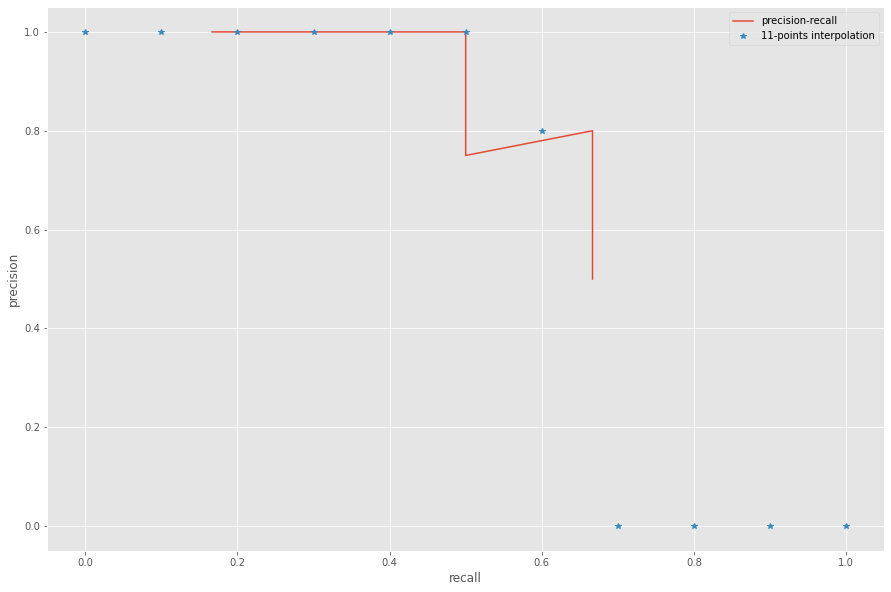

In [ ]:
ap_evaluator = AveragePrecisionEvaluator(use_07_metric=True,debug=True)
_ = ap_evaluator.run_ap_calculation(detections, ground_truths)
ap_evaluator.precision_recall_curve()

### 3.2 All-points Interpolated Precision

We now calculate the `All-points` average precision (`AP`).


----------------------------------------run_ap_calculation----------------------------------------
true positives and false positives returned from the "match" method:
true_positives:		[1. 1. 1. 0. 1. 0. 0. 0.]
false_positives:	[0. 0. 0. 1. 0. 1. 1. 1.]

true positives and false positives after cumulative sum:
self.true_positives:	[1. 2. 3. 3. 4. 4. 4. 4.]
self.false_positives:	[0. 0. 0. 1. 1. 2. 3. 4.]

precision calculated using true positive and false positive:
self.precisions:	[1.         1.         1.         0.75       0.8        0.66666667
 0.57142857 0.5       ]

recall calculated using true positive and false negative:
self.recalls:		[0.16666667 0.33333333 0.5        0.5        0.66666667 0.66666667
 0.66666667 0.66666667]

------------------------------------------get_voc_ap_all_points------------------------------------------

Recall points:
[0.         0.16666667 0.33333333 0.5        0.5        0.66666667
 0.66666667 0.66666667 0.66666667]

All-points interpolated precisi

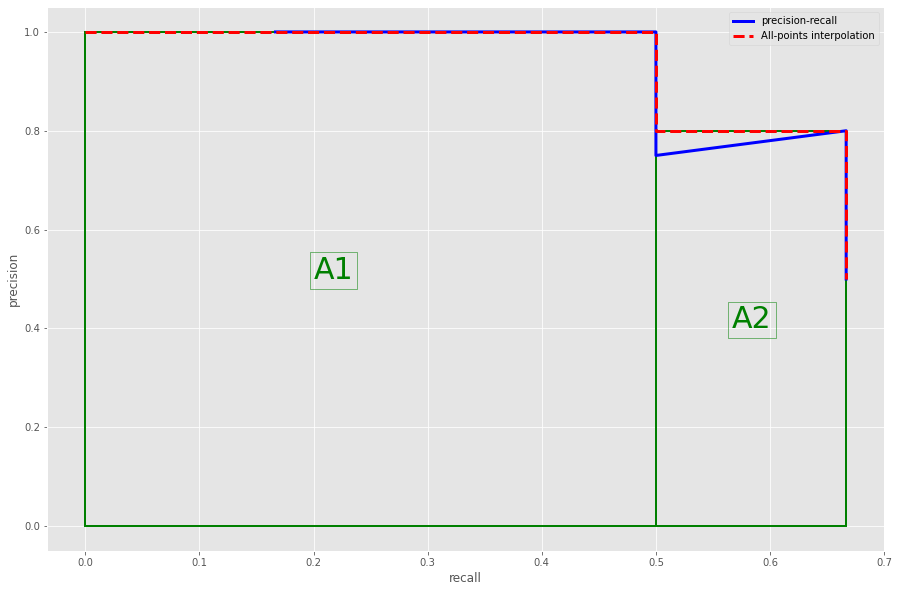

In [ ]:
ap_evaluator = AveragePrecisionEvaluator(debug=True)
ap_evaluator.run_ap_calculation(detections, ground_truths)
ap_evaluator.precision_recall_curve()

**Let's review the key points based on the results above:** 

- Detections are sorted in the descending order of confidence scores.


- Detections are categorized as true positives (`TP`) or false positives (`FP`), using the `match()` method.


- Cumulative true positives and false positives are calculated.


- Cumulative false negatives are calculated using ground truth counts and cumulative true positives. 


- Precision and recall points are calculated using cumulative true positives, false positives, and false negatives. 


- Precision is interpolated at `11-points` of recall using, $p_{\text{interp}}(r) = \underset{r':r'\geq r}\max{p(r')}$.


- Finally, average precision is calculated using, $AP = \frac{1}{11}\sum_{r\in{\{0, 0.1,...,1\}}}{p_{\text{interp}}(r)}$.


### 3.3 All-points Interpolated Precision Across Mutiple Images

We will now calculate the **`All-points`** average precision **`(AP)`** across mutiple images. Here each image is associated with an `ImageID`. We have a total of `7` images, each associated with `ImageID`s of `1, 2, ..., 7` respectively.

For instance, we have associated **Image 1** with **ImageID** as **`1`**. Now, **Image 1** has two **ground-truths** with the following box coordinates:

`[25,   16,  63,  72]`
`[129, 123, 170, 185]`

Also, it has three predictions with box cooridates:

`[  5,  67,  36, 115]`
`[119, 111, 159, 178]`
`[124,   9, 173,  76]`

with confidence scores of `0.88`, `0.70` and `0.80` respectively.

Similarly, for the other `Image ID`s as well.

In [ ]:
groundTruths =  [
                 ['1', tf.Variable([25,  16,  63,  72],  dtype=tf.float32)], 
                 ['1', tf.Variable([129, 123, 170, 185], dtype=tf.float32)],
                 ['2', tf.Variable([123,  11, 166,  66], dtype=tf.float32)],
                 ['2', tf.Variable([ 38, 132,  97, 177], dtype=tf.float32)],
                 ['3', tf.Variable([ 16,  14,  51,  62], dtype=tf.float32)],
                 ['3', tf.Variable([123,  30, 172,  74], dtype=tf.float32)],
                 ['3', tf.Variable([ 99, 139, 146, 186], dtype=tf.float32)],
                 ['4', tf.Variable([ 53,  42,  93,  94], dtype=tf.float32)],
                 ['4', tf.Variable([154,  43, 185,  77], dtype=tf.float32)],
                 ['5', tf.Variable([ 59,  31, 103,  82], dtype=tf.float32)],
                 ['5', tf.Variable([ 48, 128,  82, 180], dtype=tf.float32)],
                 ['6', tf.Variable([ 36,  89,  88, 165], dtype=tf.float32)],
                 ['6', tf.Variable([ 62,  58, 106, 125], dtype=tf.float32)],
                 ['7', tf.Variable([ 28,  31,  83,  94], dtype=tf.float32)],
                 ['7', tf.Variable([ 58,  67, 108, 125], dtype=tf.float32)]
                ]

detections = [
                 ['1', tf.Variable([  5,  67,  36, 115], dtype=tf.float32), tf.Variable(.88)], 
                 ['1', tf.Variable([119, 111, 159, 178], dtype=tf.float32), tf.Variable(.70)],
                 ['1', tf.Variable([124,   9, 173,  76], dtype=tf.float32), tf.Variable(.80)],
                 ['2', tf.Variable([ 64, 111, 128, 169], dtype=tf.float32), tf.Variable(.71)],
                 ['2', tf.Variable([ 26, 140,  86, 187], dtype=tf.float32), tf.Variable(.54)],
                 ['2', tf.Variable([ 19,  18,  62,  53], dtype=tf.float32), tf.Variable(.74)],
                 ['3', tf.Variable([109,  15, 186,  54], dtype=tf.float32), tf.Variable(.18)],
                 ['3', tf.Variable([ 86,  63, 132, 108], dtype=tf.float32), tf.Variable(.67)],
                 ['3', tf.Variable([160,  62, 196, 115], dtype=tf.float32), tf.Variable(.38)],
                 ['3', tf.Variable([105, 131, 152, 178], dtype=tf.float32), tf.Variable(.91)],
                 ['3', tf.Variable([ 18, 148,  58, 192], dtype=tf.float32), tf.Variable(.44)],
                 ['4', tf.Variable([ 83,  28, 111,  54], dtype=tf.float32), tf.Variable(.35)],
                 ['4', tf.Variable([ 28,  68,  70, 135], dtype=tf.float32), tf.Variable(.78)],
                 ['4', tf.Variable([ 87,  89, 112, 128], dtype=tf.float32), tf.Variable(.45)],
                 ['4', tf.Variable([ 10, 155,  70, 181], dtype=tf.float32), tf.Variable(.14)],
                 ['5', tf.Variable([ 50,  38,  78,  84], dtype=tf.float32), tf.Variable(.62)],
                 ['5', tf.Variable([ 95,  11, 148,  39], dtype=tf.float32), tf.Variable(.44)],
                 ['5', tf.Variable([ 29, 131, 101, 160], dtype=tf.float32), tf.Variable(.95)],
                 ['5', tf.Variable([ 29, 163, 101, 192], dtype=tf.float32), tf.Variable(.23)],
                 ['6', tf.Variable([ 43,  48, 117,  86], dtype=tf.float32), tf.Variable(.45)],
                 ['6', tf.Variable([ 17, 155,  46, 190], dtype=tf.float32), tf.Variable(.84)],
                 ['6', tf.Variable([ 95, 110, 120, 152], dtype=tf.float32), tf.Variable(.43)],
                 ['7', tf.Variable([ 16,  20, 117, 108], dtype=tf.float32), tf.Variable(.48)],
                 ['7', tf.Variable([ 33, 116,  70, 165], dtype=tf.float32), tf.Variable(.95)]
                ]


----------------------------------------run_ap_calculation----------------------------------------
true positives and false positives returned from the "match" method:
true_positives:		[1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
false_positives:	[0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]

true positives and false positives after cumulative sum:
self.true_positives:	[1. 1. 2. 2. 2. 2. 2. 2. 2. 3. 3. 4. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 7. 7.]
self.false_positives:	[ 0.  1.  1.  2.  3.  4.  5.  6.  7.  7.  8.  8.  8.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 16. 17.]

precision calculated using true positive and false positive:
self.precisions:	[1.         0.5        0.66666667 0.5        0.4        0.33333333
 0.28571429 0.25       0.22222222 0.3        0.27272727 0.33333333
 0.38461538 0.42857143 0.4        0.375      0.35294118 0.33333333
 0.31578947 0.3        0.28571429 0.27272727 0.30434783 0.29166667]

recall calculated using tr

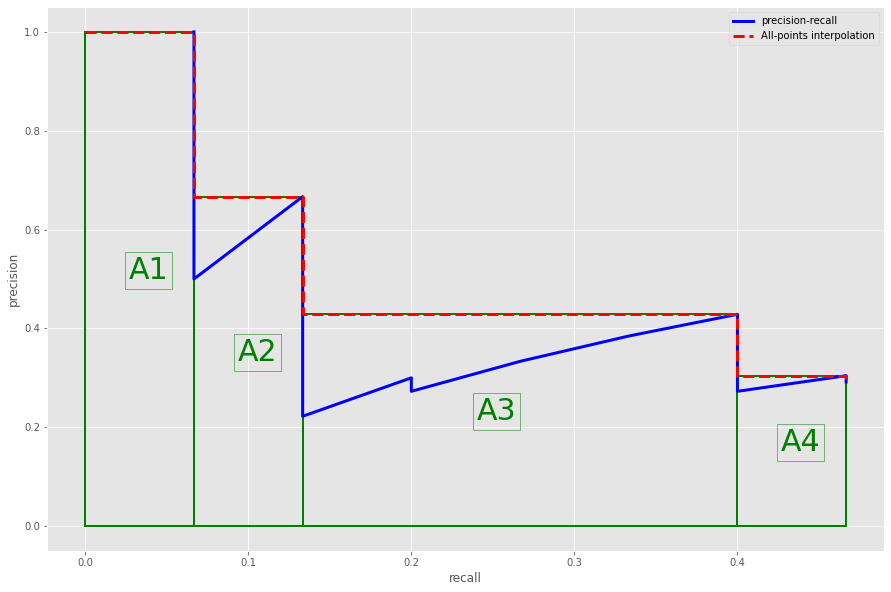

In [ ]:
ap_evaluator = AveragePrecisionEvaluator(intersection_threshold=0.3, debug=True)
ap_evaluator.run_ap_calculation(detections,groundTruths)
ap_evaluator.precision_recall_curve()

## 4 Mean Average Precision (mAP)

In the previous section, Average-Precision is implemented for a single class because we wanted to focus just on the concept of average precision. 

If there is more than one class, the **mean average precision (`mAP`)** is defined as the mean of the average precision across all classes. Formally, it is written as follows:

$$
mAP =  \frac{1}{N}\sum_{class=0}^{N}{AP_{class}}
$$

Extending this metric to multiple classes is just an implementation detail and quite easy to do. We will use this metric in a subsequent notebook to quantify the accuracy of object detection results.

## 5  References

* https://github.com/rafaelpadilla/Object-Detection-Metrics

* http://host.robots.ox.ac.uk/pascal/VOC/voc2010/devkit_doc_08-May-2010.pdf

* http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf